**OSM Daten: Straßennetz und Feature Engineering**

- Straßennetz von Köln via OSMnx laden
- Infrastruktur-Features (Ampeln, Zebrastreifen, Gehwege, Parkplätze) per Spatial Join an Straßen anhängen
- Lanes und Maxspeed bereinigen und fehlende Werte nach Straßentyp imputieren
- Unfalldaten an nächste Straße matchen (max 30m)



In [1]:
!pip install osmnx geopandas tqdm -q

import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
from shapely.geometry import Point
from tqdm.notebook import tqdm
tqdm.pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 1.9 MB/s eta 0:00:00


### Straßennetz laden
- OSMnx lädt das komplette Netz
- Ergebnis: Kanten (Straßenabschnitte) und Knoten (Kreuzungen)

In [2]:
G = ox.graph_from_place("Köln, Germany", network_type='drive')
nodes, edges = ox.graph_to_gdfs(G)

print(f"Kanten: {edges.shape[0]}, Knoten: {nodes.shape[0]}")
print(f"Spalten: {edges.shape[1]}")

Kanten: 36254, Knoten: 16390
Spalten: 15


### Straßennetz visualisieren
- Einfärbung nach Straßentyp: Autobahn rot, Hauptstraßen orange/gelb, Nebenstraßen blau/grün

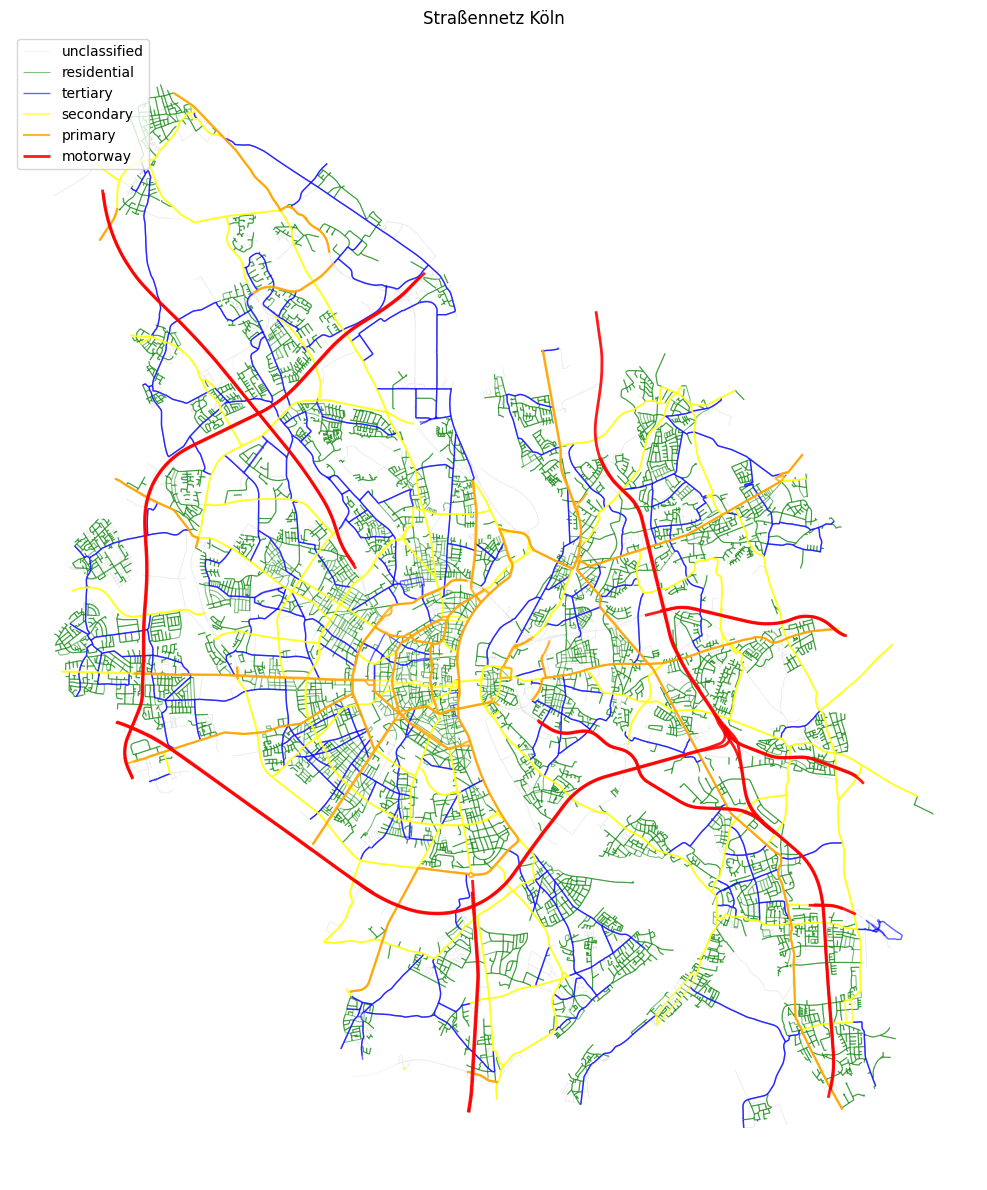

In [3]:
key_highways = ['motorway', 'primary', 'secondary', 'tertiary', 'residential']

edges['plot_color'] = edges['highway'].apply(
    lambda x: x if isinstance(x, str) and x in key_highways else 'unclassified'
)

fig, ax = plt.subplots(figsize=(12, 12))

# Unwichtige zuerst, wichtige oben drauf
color_map = {
    'unclassified': ('lightgray', 0.3, 0.5),
    'residential': ('green', 0.5, 0.8),
    'tertiary': ('blue', 0.6, 1.0),
    'secondary': ('yellow', 0.7, 1.2),
    'primary': ('orange', 0.8, 1.5),
    'motorway': ('red', 0.9, 2.0),
}
for hw, (color, alpha, lw) in color_map.items():
    subset = edges[edges['plot_color'] == hw]
    if len(subset) > 0:
        subset.plot(ax=ax, color=color, alpha=alpha, linewidth=lw, label=hw)

ax.legend(loc='upper left')
ax.set_title("Straßennetz Köln")
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Infrastruktur-Features von OSM
- Ampeln, Zebrastreifen, Parkplätze, Gehwege per Overpass API laden
- Per STRtree Spatial Index prüfen ob ein Feature innerhalb 5m (bzw. 10m bei Parking) einer Straßenkante liegt

In [4]:
place_name = "Köln, Deutschland"

traffic_signals = ox.features_from_place(place_name, tags={"highway": "traffic_signals"})
crossings = ox.features_from_place(place_name, tags={"highway": "crossing"})
parking = ox.features_from_place(place_name, tags={"amenity": "parking"})
sidewalks = ox.features_from_place(place_name, tags={"highway": "footway"})

print(f"Ampeln: {len(traffic_signals)}")
print(f"Zebrastreifen: {len(crossings)}")
print(f"Parkflächen: {len(parking)}")
print(f"Gehwege: {len(sidewalks)}")

Ampeln: 3547
Zebrastreifen: 6981
Parkflächen: 20847
Gehwege: 15829


In [5]:
# Alles auf UTM für Meter-Berechnungen
edges = edges.to_crs(epsg=25832)
for gdf in [traffic_signals, crossings, sidewalks, parking]:
    gdf.to_crs(epsg=25832, inplace=True)

# STRtree für schnelle Abfragen
tree_signals = STRtree(traffic_signals.geometry)
tree_crossings = STRtree(crossings.geometry)
tree_sidewalks = STRtree(sidewalks.geometry)
tree_parking = STRtree(parking.geometry)

def has_nearby(geom, tree, buffer_m=5):
    # Prüft ob mindestens ein Objekt im Umkreis liegt
    try:
        return any(tree.query(geom.buffer(buffer_m)))
    except:
        return False

edges['has_signal'] = edges.geometry.progress_apply(lambda g: has_nearby(g, tree_signals))
edges['has_crossing'] = edges.geometry.progress_apply(lambda g: has_nearby(g, tree_crossings))
edges['has_sidewalk'] = edges.geometry.progress_apply(lambda g: has_nearby(g, tree_sidewalks))
edges['has_parking'] = edges.geometry.progress_apply(lambda g: has_nearby(g, tree_parking, buffer_m=10))  # größerer Radius

for col in ['has_signal', 'has_crossing', 'has_sidewalk', 'has_parking']:
    print(f"{col:17s}: {edges[col].sum():5d} True ({edges[col].mean()*100:.1f}%)")

  0%|          | 0/36254 [00:00<?, ?it/s]

  0%|          | 0/36254 [00:00<?, ?it/s]

  0%|          | 0/36254 [00:00<?, ?it/s]

  0%|          | 0/36254 [00:00<?, ?it/s]

has_signal       :  5939 True (16.4%)
has_crossing     :  9866 True (27.2%)
has_sidewalk     : 13496 True (37.2%)
has_parking      : 18003 True (49.7%)


### Lanes und Maxspeed bereinigen
- OSM speichert lanes/maxspeed manchmal als Liste (z.B. "2, 3") -> Maximum nehmen
- Fehlende Werte nach Straßentyp imputieren (z.B. residential = 30 km/h, 1 Spur)

In [6]:
# Listen in einzelne Werte umwandeln
for col in ['highway', 'lanes', 'maxspeed']:
    edges[col] = edges[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

def parse_numeric(x):
    # Extrahiert den höchsten numerischen Wert aus einem String
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        parts = [p.strip() for p in x.split(',') if p.strip().isdigit()]
        if len(parts) == 0:
            return np.nan
        return int(max(map(int, parts)))
    return x

edges['lanes_clean'] = edges['lanes'].apply(parse_numeric)
edges['maxspeed_clean'] = edges['maxspeed'].apply(parse_numeric)

print(f"lanes_clean NaN: {edges['lanes_clean'].isna().sum()} ({edges['lanes_clean'].isna().mean()*100:.0f}%)")
print(f"maxspeed_clean NaN: {edges['maxspeed_clean'].isna().sum()} ({edges['maxspeed_clean'].isna().mean()*100:.0f}%)")

lanes_clean NaN: 18765 (52%)
maxspeed_clean NaN: 9460 (26%)


In [7]:
# Defaults pro Straßentyp (OpenStreetMap Wiki)
lanes_defaults = {
    'motorway': 3, 'motorway_link': 2,
    'trunk': 2, 'trunk_link': 2,
    'primary': 2, 'primary_link': 2,
    'secondary': 2, 'secondary_link': 2,
    'tertiary': 1, 'tertiary_link': 1,
    'residential': 1, 'living_street': 1, 'unclassified': 1
}

speed_defaults = {
    'motorway': 120, 'motorway_link': 100,
    'trunk': 100, 'trunk_link': 80,
    'primary': 70, 'primary_link': 60,
    'secondary': 60, 'secondary_link': 50,
    'tertiary': 50, 'tertiary_link': 50,
    'residential': 30, 'living_street': 20, 'unclassified': 50
}

# Vorhandene Werte behalten, nur NaN auffüllen
edges['lanes_imputed'] = edges.apply(
    lambda row: row['lanes_clean'] if not pd.isna(row['lanes_clean'])
    else lanes_defaults.get(row['highway'], 1),
    axis=1
)

edges['maxspeed_imputed'] = edges.apply(
    lambda row: row['maxspeed_clean'] if not pd.isna(row['maxspeed_clean'])
    else speed_defaults.get(row['highway'], 50),
    axis=1
)

print(f"lanes NaN vorher: {edges['lanes_clean'].isna().sum()} -> nachher: {edges['lanes_imputed'].isna().sum()}")
print(f"maxspeed NaN vorher: {edges['maxspeed_clean'].isna().sum()} -> nachher: {edges['maxspeed_imputed'].isna().sum()}")

lanes NaN vorher: 18765 -> nachher: 0
maxspeed NaN vorher: 9460 -> nachher: 0


### Spalten bereinigen und Typen anpassen
- Rohe lanes/maxspeed Spalten raus (haben jetzt clean/imputed Versionen)
- OSM Metadaten (osmid, name, ref) raus, werden nicht gebraucht

In [8]:
# Nicht mehr benötigte Spalten
drop_cols = ['osmid', 'name', 'ref', 'bridge', 'tunnel', 'junction',
             'access', 'width', 'lanes', 'maxspeed', 'plot_color']
edges = edges.drop(columns=[col for col in drop_cols if col in edges.columns])

# reversed: manchmal als Liste gespeichert
edges['reversed'] = edges['reversed'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
).astype(int)

# Booleans zu int (für LightGBM)
for col in ['oneway', 'has_signal', 'has_crossing', 'has_sidewalk', 'has_parking']:
    edges[col] = edges[col].astype(int)

edges['highway'] = edges['highway'].astype('category')

print(f"Edges: {edges.shape[0]} Zeilen, {edges.shape[1]} Spalten")

Edges: 36254 Zeilen, 13 Spalten


### Unfalldaten laden und an Straßen matchen
- Jeder Unfall wird per sjoin_nearest an die nächste Straße gematcht (max 30m)
- Bei mehreren Matches wird die nächstgelegene Straße behalten

In [10]:
unfaelle = pd.read_parquet("unfaelle.parquet")

# Kategorische Spalten markieren
for col in ['UART', 'UTYP1', 'ULICHTVERH']:
    unfaelle[col] = unfaelle[col].astype('category')

print(f"Unfälle: {len(unfaelle)} Zeilen, {unfaelle.shape[1]} Spalten")

Unfälle: 12488 Zeilen, 46 Spalten


In [11]:
# Unfälle als GeoDataFrame
unfaelle['geometry'] = unfaelle.apply(lambda row: Point(row['XGCSWGS84'], row['YGCSWGS84']), axis=1)
unfaelle_gdf = gpd.GeoDataFrame(unfaelle, geometry='geometry', crs='EPSG:4326')

# Beide auf UTM
unfaelle_gdf = unfaelle_gdf.to_crs('EPSG:25832')
edges = edges.to_crs('EPSG:25832')

# Nearest Join: jeder Unfall bekommt die nächste Straße (max 30m)
unfaelle_gdf['temp_id'] = range(len(unfaelle_gdf))
unfaelle_merged = unfaelle_gdf.sjoin_nearest(
    edges, how='left', max_distance=30, distance_col='street_distance'
)

print(f"Nach Join: {len(unfaelle_merged)} Zeilen (vorher {len(unfaelle_gdf)})")
print(f"Ohne Straße (<30m): {unfaelle_merged['highway'].isna().sum()}")

# Bei mehreren Matches: nächste Straße behalten
multi = unfaelle_merged.groupby('temp_id').size()
print(f"Mehrfach-Matches: {(multi > 1).sum()}")

unfaelle_merged = unfaelle_merged.sort_values('street_distance').drop_duplicates(
    subset='temp_id', keep='first'
)
print(f"Nach Deduplizierung: {len(unfaelle_merged)} Zeilen")

Nach Join: 14998 Zeilen (vorher 12488)
Ohne Straße (<30m): 223
Mehrfach-Matches: 2502
Nach Deduplizierung: 12488 Zeilen


In [12]:
# Hilfsspalten raus und speichern
unfaelle_final = unfaelle_merged.drop(columns=['temp_id', 'u', 'v', 'key', 'street_distance'])

edges.to_parquet('edges_features.parquet')
unfaelle_final.to_parquet('unfaelle_mit_strassen.parquet')

print(f"edges_features.parquet: {edges.shape}")
print(f"unfaelle_mit_strassen.parquet: {unfaelle_final.shape}")

edges_features.parquet: (36254, 13)
unfaelle_mit_strassen.parquet: (12488, 59)
